In [2]:
import os
import numpy as np
import struct
from numpy import zeros
import array
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
def load_mnist(dataset="training", digits=np.arange(10), path=".", size = 60000):
    if dataset == "training":
        fname_img = os.path.join(path, 'train-images.idx3-ubyte')
        fname_lbl = os.path.join(path, 'train-labels.idx1-ubyte')
    elif dataset == "testing":
        fname_img = os.path.join(path, 't10k-images.idx3-ubyte')
        fname_lbl = os.path.join(path, 't10k-labels.idx1-ubyte')
    else:
        raise ValueError("dataset must be 'testing' or 'training'")

    flbl = open(fname_lbl, 'rb')
    magic_nr, size = struct.unpack(">II", flbl.read(8))
    lbl = array.array("b", flbl.read())
    flbl.close()

    fimg = open(fname_img, 'rb')
    magic_nr, size, rows, cols = struct.unpack(">IIII", fimg.read(16))
    img = array.array("B", fimg.read())
    fimg.close()

    ind = [ k for k in range(size) if lbl[k] in digits ]
    N = size #int(len(ind) * size/100.)
    images = zeros((N, rows, cols), dtype='uint8')
    labels = zeros((N, 1), dtype='int8')
    for i in range(N): #int(len(ind) * size/100.)):
        images[i] = np.array(img[ ind[i]*rows*cols : (ind[i]+1)*rows*cols ])\
            .reshape((rows, cols))
        labels[i] = lbl[ind[i]]
    labels = [label[0] for label in labels]
    return images, labels

In [4]:
tr,label = load_mnist()
tr = tr/256
tr_label = np.array(label,dtype = np.long)
te,te_label = load_mnist("testing")
te = te/256
te_label = np.array(te_label,dtype = np.long)

In [5]:
# import needed library for MLP 
import torch
import torch.nn as nn
import torch.nn.functional
import torch.utils.data
from torch.autograd import Variable

In [6]:
train_data =torch.utils.data.DataLoader(torch.from_numpy(tr),batch_size = 100)
test_data =torch.utils.data.DataLoader(torch.from_numpy(te),batch_size = 100)
train_label =torch.from_numpy(tr_label)
test_label = torch.from_numpy(te_label)

In [11]:
#build MLP
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.L1 = nn.Linear(784,610)
        self.L2 = nn.Linear(610,310)
        self.L3 = nn.Linear(310,10)

    def forward(self,din):
        din = din.view(-1,28*28)
        dout = torch.nn.functional.relu(self.L1(din))
        dout = torch.nn.functional.relu(self.L2(dout))
        return torch.nn.functional.softmax(self.L3(dout))
#calculate accuracy
def accuracy(preb,label):
    preb = preb.cpu().data.numpy()
    label = label.cpu().data.numpy()
    test_np = (np.argmax(preb,1)==label)
    test_np = np.float32(test_np)
    return (100*np.mean(test_np))

In [21]:
def train(ipnut_data,input_label,momentum):
    model = MLP().cuda()
    sgd = torch.optim.SGD(model.parameters(),lr = 0.1, momentum = momentum)
    lossfunc = torch.nn.CrossEntropyLoss()
    trace = []
    for n in range(50):
        sums = []
        for i,data in enumerate(ipnut_data):
            sgd.zero_grad()
            data = data.type(torch.FloatTensor)
            labels = input_label[i*100:i*100+100].type(torch.LongTensor)
            inputs = torch.autograd.Variable(data).cuda()
            labels = torch.autograd.Variable(labels).cuda()
            outputs = model(inputs)
            loss = lossfunc(outputs,labels)
            loss.backward()
            sgd.step()
            sums.append(accuracy(outputs,labels))
        trace.append(sum(sums)/len(sums))
    return trace,model

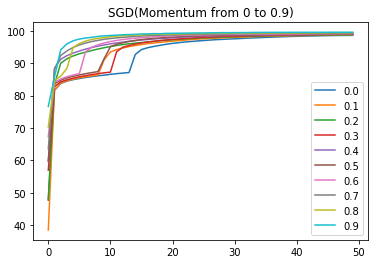

In [13]:
mo = np.arange(0,1,0.1)
plt.title('SGD(Momentum from 0 to 0.9)')
for i in range(10):
    trace = train(train_data,train_label,mo[i])
    plt.plot(trace,label=mo[i])
    plt.legend(loc = 'lower right')
plt.savefig('SGD_compare_without_dropout.png')

In [14]:
print(trace)

[76.65666661659877, 85.836666504542038, 94.136666874090835, 96.00833396116893, 96.961667398611709, 97.490000923474625, 97.80833426117897, 98.033334225416183, 98.306667705376938, 98.495000978310898, 98.585000932216644, 98.711667627096176, 98.831667542457581, 98.88666757941246, 98.950000862280532, 99.053334146738052, 99.080000768105194, 99.168334086736039, 99.140000720818833, 99.246667335430786, 99.261667321125671, 99.29666728774707, 99.313333978255585, 99.340000599622726, 99.365000585714981, 99.371667226155594, 99.408333867788315, 99.438333859046296, 99.476667155822113, 99.466667155424759, 99.481667141119644, 99.48833381136258, 99.506667107343674, 99.538333763678864, 99.545000423987702, 99.558333744605378, 99.566667069991425, 99.566667069991425, 99.566667069991425, 99.576667060454682, 99.58166705568631, 99.586667050917939, 99.586667050917939, 99.586667050917939, 99.585000385840729, 99.588333715995148, 99.590000381072358, 99.593333711226776, 99.595000376303986, 99.596667041381195]


In [22]:
trace,model_b = train(train_data,train_label,0.9)

In [27]:
def MSE(preb,label):
    sums = 0
    preb = preb.cpu().data.numpy()
    label = label.cpu().data.numpy()
    re = np.argmax(preb,1)
    label = np.float32(label)
    for o in range(100):
        sums = sums+(re[o]-label[o])**2
    return (sums/100)

In [31]:
sums=[]
mse=[]
for i,data in enumerate(test_data):
    print(data.shape)
    data = data.type(torch.FloatTensor)
    labels = test_label[i*100:i*100+100].type(torch.LongTensor)
    inputs = torch.autograd.Variable(data).cuda()
    labels = torch.autograd.Variable(labels).cuda()
    outputs = model_b(inputs)
    sums.append(accuracy(outputs,labels))
    mse.append(MSE(outputs,labels))
print(sum(sums)/len(sums))
print(sum(mse)/len(mse))

torch.Size([100, 28, 28])
torch.Size([100, 28, 28])
torch.Size([100, 28, 28])
torch.Size([100, 28, 28])
torch.Size([100, 28, 28])
torch.Size([100, 28, 28])
torch.Size([100, 28, 28])
torch.Size([100, 28, 28])
torch.Size([100, 28, 28])
torch.Size([100, 28, 28])
torch.Size([100, 28, 28])
torch.Size([100, 28, 28])
torch.Size([100, 28, 28])
torch.Size([100, 28, 28])
torch.Size([100, 28, 28])
torch.Size([100, 28, 28])
torch.Size([100, 28, 28])
torch.Size([100, 28, 28])
torch.Size([100, 28, 28])
torch.Size([100, 28, 28])
torch.Size([100, 28, 28])
torch.Size([100, 28, 28])
torch.Size([100, 28, 28])
torch.Size([100, 28, 28])
torch.Size([100, 28, 28])
torch.Size([100, 28, 28])
torch.Size([100, 28, 28])
torch.Size([100, 28, 28])
torch.Size([100, 28, 28])
torch.Size([100, 28, 28])
torch.Size([100, 28, 28])
torch.Size([100, 28, 28])
torch.Size([100, 28, 28])
torch.Size([100, 28, 28])
torch.Size([100, 28, 28])
torch.Size([100, 28, 28])
torch.Size([100, 28, 28])
torch.Size([100, 28, 28])
torch.Size([